In [1]:
%matplotlib inline

In [162]:
from chmp.ds import reload
reload('chmp.ml', 'chmp.ds', 'chmp.bayes')

<module 'chmp.bayes' from '/Volumes/Home/Code/misc-exp/chmp/src/chmp/bayes/__init__.py'>

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tqdm import tqdm

from chmp.bayes import Model, sample_latent, sample_prior
from chmp.ds import mpl_set, get_color_cycle, colormap
from chmp.ml import get_variables, make_distribution

# Implicit Variational Inference

Based on:

- D Tran, R Ranganath, DM Blei, ["Hierarchical Implicit Models and Likelihood-Free Variational Inference"](https://arxiv.org/abs/1702.08896), 2017.
- F Huszár, ["Variational Inference using Implicit Models"](http://www.inference.vc/variational-inference-using-implicit-models/).


$$
\begin{align}
    \mathcal{L}_q 
        &= \mathbb{E}_{q(z)} \log \frac{p(x, z)}{q(z)} \\
        &= \mathbb{E}_{q(z)} \log p(x|z) + \mathbb{E}_{q(z)} \log \frac{p(z)}{q(z)} \\
        &\approx \mathbb{E}_{q(z)} \log p(x|z) + \mathbb{E}_{q(z)} r(z)
\end{align}
$$

Where $r$ *maximizes*:

$$
    \mathcal{L}_r = 
        \mathbb{E}_{p(z)} \big[ \log \sigma(r(z)) \big] +
        \mathbb{E}_{q(z)} \big[ \log\big( 1 - \sigma(r(z)) \big) \big]
$$

At optimiality $r^\star(z) = \log p(z) - \log q(z)$.

## Example: Gaussian

Target density:

$$
    p(x) = \mathcal{N}(x | \mu_p = 5, \sigma_p = 2)
$$

Generators:

$$
    x = \mu_q + \sigma_p \epsilon \sim q(x) \\
    \epsilon \sim \mathcal{N}(0, 1)
$$

Log-ratio approximation:
$$
    r(x) = b_0 + b_1 x + b_2 x^2 
$$

Note, that $r(x)$ is able to fit the log ratio exactly.


In [96]:
tf.reset_default_graph()

n_samples = 10

p_ = tf.random_normal((n_samples,), mean=5.0, stddev=2.0)

def sample_q():
    with tf.variable_scope('q', reuse=tf.AUTO_REUSE):
        mu_ = tf.get_variable('mu', initializer=0.0, dtype=tf.float32)
        sigma_ = tf.nn.softplus(tf.get_variable('sigma', initializer=1.0, dtype=tf.float32))

        return mu_ + sigma_ * tf.random_normal((n_samples,))


def apply_r(x):
    with tf.variable_scope('r', reuse=tf.AUTO_REUSE):
        b0_ = tf.get_variable('b', initializer=0.0, dtype=tf.float32)
        b1_ = tf.get_variable('b1', initializer=1.0, dtype=tf.float32)
        b2_ = tf.get_variable('b2', initializer=0.5, dtype=tf.float32)
        
        return b0_ + b1_ * x + b2_ * (x ** 2.0)
    
    
q_ = sample_q()
ratio_loss_ = -tf.reduce_mean(
    tf.log(tf.sigmoid(apply_r(p_))) +
    tf.log(1 - tf.sigmoid(apply_r(sample_q())))
)

kl_loss_ = -tf.reduce_mean(apply_r(sample_q()))

train_q_ = tf.train.AdamOptimizer(0.01).minimize(kl_loss_, var_list=get_variables('q/'))
train_r_ = tf.train.AdamOptimizer(0.05).minimize(ratio_loss_, var_list=get_variables('r/'))

In [97]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for _ in range(10_000):
        sess.run(train_r_)
        sess.run(train_q_)
    
    q = [sess.run(q_) for _ in range(100)]
    p = [sess.run(p_) for _ in range(100)]

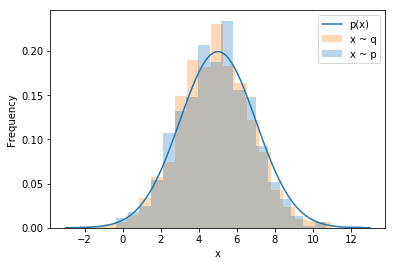

In [98]:
c0, c1 = get_color_cycle(2)

plt.hist(np.reshape(q, -1), bins=21, normed=True, alpha=0.3, label='x ~ q', color=c1)
plt.hist(np.reshape(p, -1), bins=21, normed=True, alpha=0.3, label='x ~ p', color=c0)

t = np.linspace(-3, 13, 100)
plt.plot(
    t, np.exp(-0.5 * (t - 5.) ** 2.0 / (4.)) / np.sqrt(2. * np.pi * 4.), 
    label='p(x)', color=c0,
)

mpl_set(xlabel='x', ylabel='Frequency', legend=True)
pass

## Mixture of Gaussians

In [381]:
tf.reset_default_graph()

n_samples = 10

u_ = tf.cast(tf.random_uniform([n_samples]) > 0.4, tf.float32)
p_ = (
    u_ * tf.random_normal([n_samples], mean=-2, stddev=1.0) + 
    (1 - u_) * tf.random_normal([n_samples], mean=4.0, stddev=0.5)
)


def sample_q():
    with tf.variable_scope('q', reuse=tf.AUTO_REUSE):
        mu_ = tf.get_variable('mu', initializer=np.random.uniform(-5., 5.0, size=(4,)).astype(np.float32), dtype=tf.float32)
        sigma_ = tf.nn.softplus(tf.get_variable('sigma', initializer=5.0 * np.ones(4, dtype=np.float32), dtype=tf.float32))
        
        theta_ = tf.get_variable('theta', initializer=0.1 * np.ones(4, dtype=np.float32), dtype=tf.float32)
        
        u_ = tf.contrib.distributions.RelaxedOneHotCategorical(0.1, logits=theta_).sample([n_samples])
        
        mu_ = tf.expand_dims(mu_, axis=0)
        sigma_ = tf.expand_dims(sigma_, axis=0)
        
        return tf.reduce_sum(
            u_ * (mu_ + sigma_ * tf.random_normal((n_samples, 4))),
            axis=-1,
        )

b_init_ = np.random.uniform(-1e-3, +1e-3, size=(3, 10)).astype(np.float32)
mu_init_ = np.random.uniform(-10., 10., size=(10,)).astype(np.float32)
sigma_init_ = (0.01 + np.random.normal(size=(10,)) ** 2.0).astype(np.float32)


def apply_r(x):
    with tf.variable_scope('r', reuse=tf.AUTO_REUSE):
        b0_ = tf.get_variable('b0', initializer=[1., 0.01, 0.01], dtype=tf.float32)
        b_ = tf.get_variable('b', initializer=b_init_, dtype=tf.float32)
        mu_ = tf.get_variable('mu', initializer=mu_init_, dtype=tf.float32)
        sigma_ = tf.get_variable('sigma', initializer=sigma_init_, dtype=tf.float32)
        
        x1 = tf.expand_dims(x, axis=-1)
        x2 = tf.expand_dims(x1, axis=-1)
        
        b_ = tf.expand_dims(b_, axis=0)
        n = tf.expand_dims(tf.expand_dims(tf.range(3, dtype=tf.float32), axis=0), axis=-1)
        
        mu_ = tf.expand_dims(mu_, axis=0)
        sigma_ = tf.expand_dims(sigma_, axis=0)
                
        base = b0_[0] + b0_[1] * x + b0_[2] * x ** 2.
        delta = tf.reduce_mean(
            tf.reduce_sum(b_ * (x2 - mu_) ** n, axis=1) * (tf.exp(-0.5 * (x1 - mu_) ** 2.0 / sigma_ ** 2.0) / sigma_),
            axis=1,
        )

        return base + delta

    
q_ = sample_q()
ratio_loss_ = -tf.reduce_mean(
    tf.log(tf.sigmoid(apply_r(p_))) +
    tf.log(1 - tf.sigmoid(apply_r(sample_q())))
)

kl_loss_ = -tf.reduce_mean(apply_r(sample_q()))

train_q_ = tf.train.AdamOptimizer(0.01).minimize(kl_loss_, var_list=get_variables('q/'))
train_r_ = tf.train.AdamOptimizer(0.1).minimize(ratio_loss_, var_list=get_variables('r/'))

t_ = tf.linspace(-10., 10., 100)
r_ = apply_r(t_)

In [382]:
from tqdm import tqdm

In [383]:
ratios = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for iteration in tqdm(range(10_000)): #10_000):
        if iteration % 200 == 0:
            ratios.append(sess.run([t_, r_]))
            sess.run(tf.verify_tensor_all_finite(q_, 'nans detected'))
            
        sess.run(train_r_)
        sess.run(train_q_)
    
    q = [sess.run(q_) for _ in range(100)]
    p = [sess.run(p_) for _ in range(100)]
    
ratios = np.asarray(ratios)

100%|██████████| 10000/10000 [00:28<00:00, 355.06it/s]


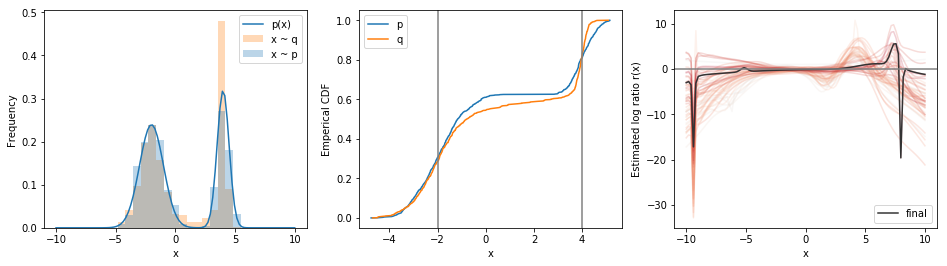

In [388]:
c0, c1 = get_color_cycle(2)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.hist(np.reshape(q, -1), range=(-10, +10), bins=31, normed=True, alpha=0.3, label='x ~ q', color=c1)
plt.hist(np.reshape(p, -1), range=(-10, +10), bins=31, normed=True, alpha=0.3, label='x ~ p', color=c0)

t = np.linspace(-10, 10, 100)
plt.plot(
    t, 
    0.6 * np.exp(-0.5 * (t + 2.) ** 2.0) / np.sqrt(2. * np.pi) + 
    0.4 * np.exp(-0.5 * ((t - 4) / 0.5) ** 2.0) / np.sqrt(2.0 * np.pi * 0.5 ** 2.0),
    label='p(x)', color=c0,
)

mpl_set(xlabel='x', ylabel='Frequency', legend=True)

plt.subplot(1, 3, 2)
plt.plot(np.sort(np.reshape(p, -1)), np.linspace(0, 1, np.size(p)), label='p', color=c0)
plt.plot(np.sort(np.reshape(q, -1)), np.linspace(0, 1, np.size(q)), label='q', color=c1)
plt.axvline(x=-2, color='0.5')
plt.axvline(x=4, color='0.5')
mpl_set(xlabel='x', ylabel='Emperical CDF', legend=True)

plt.subplot(1, 3, 3)
for color, ratio in zip(colormap(range(len(ratios))), ratios):
    plt.plot(ratio[0], ratio[1], color=color, alpha=0.2)

plt.plot(ratios[-1, 0], ratios[-1, 1], color='0.2', label='final')
plt.axhline(y=0, c='0.5')
mpl_set(xlabel='x', ylabel='Estimated log ratio r(x)', legend=True)
pass

## Linear regression

In [65]:
n_features = 10
n_samples = 100

np.random.seed(1234)
w = np.random.normal(scale=4, size=n_features)
x = np.random.uniform(-10, +10, size=(n_samples, n_features))

y = x @ np.random.normal(w, scale=0.2) 

(array([  2.,   4.,  12.,  15.,  19.,  21.,   8.,  10.,   4.,   5.]),
 array([-9.19421669, -7.37883546, -5.56345422, -3.74807299, -1.93269175,
        -0.11731052,  1.69807072,  3.51345195,  5.32883319,  7.14421442,
         8.95959566]),
 <a list of 10 Patch objects>)

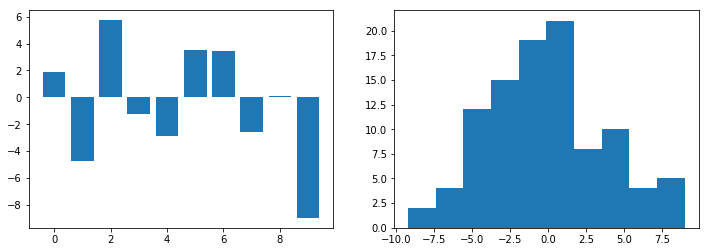

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(w)), w)

plt.subplot(1, 2, 2)
plt.hist(y - x @ w)

In [246]:
def build_implicit_losses(model, discriminator):
    # TODO: set variable scopes in strategy?
    model_scope = model.build(ensure_loss=False, latent_strategy=sample_prior)
    inference_scope = model.build(ensure_loss=False, latent_strategy=sample_latent)
    
    if model_scope['loss'] is not None or inference_scope['loss'] is not None:
        raise RuntimeError('cannot handle custom losses ...')
    
    latent = {*model_scope['latent'], *inference_scope['latent']}
    observed = {*model_scope['observed'], *inference_scope['observed']} & {*model_scope['p'], *inference_scope['p']}
    
    ratio_loss = 0
    for k in latent:
        ratio_loss += tf.reduce_mean(
            tf.log(tf.sigmoid(discriminator(model_scope['latent'][k]))) +
            tf.log(1 - tf.sigmoid(discriminator(inference_scope['latent'][k])))
        )
    
    kl_loss = 0
    for k in observed:
        px = inference_scope['p'][k]
        x = inference_scope['observed'][k]
        kl_loss += tf.reduce_mean(px.log_prob(x))
    
    for k in scope['latent']:
        kl_loss += tf.reduce_mean(discriminator(inference_scope['latent'][k]))
    
    return -kl_loss, -ratio_loss

In [255]:
tf.reset_default_graph()

# TODO: fix scoping issue
generator_scope = tf.VariableScope(name='generator', reuse=tf.AUTO_REUSE)

def generator():
    with tf.variable_scope(generator_scope):
        x = tf.random_normal([n_samples, n_features])

        mean = tf.get_variable('mean', n_features, dtype=tf.float32)
        scale = tf.nn.softplus(tf.get_variable('scale', n_features, dtype=tf.float32))

        return mean[None, :] + scale[None, :] * x
    
    
def discriminator(weights):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        x = tf.layers.dense(weights, 10, activation=tf.nn.relu, name='layer1')
        x = tf.layers.dense(weights, 10, activation=tf.nn.relu, name='layer2')
        x = tf.layers.dense(x, 1, name='layer3')
    return x
    

with Model() as model:
    @model.observe
    def _(s):
        s.x = tf.placeholder(name='x', dtype=tf.float32, shape=(n_samples, n_features))
        s.y = tf.placeholder(name='y', dtype=tf.float32, shape=n_samples)
    
    @model.define
    def _(s):
        s.p.z = tf.distributions.Normal(loc=tf.zeros([n_samples, n_features]), scale=2.0)
        s.p.y = tf.distributions.Normal(tf.reduce_sum(s.x * s.z, axis=1), 1.0)
    
    @model.inference
    def _(s):
        s.q.z = make_distribution(generator, batch_shape=[n_samples], event_shape=[n_features])
    

kl_loss_, ratio_loss_ = build_implicit_losses(model, discriminator)

z_ = model.build(ensure_loss=False)['latent']['z']
x_, y_ = model['x', 'y']

# NOTE: supplying var_list is important
train_r_ = tf.train.AdamOptimizer(0.01).minimize(ratio_loss_, var_list=get_variables('discriminator'))
train_q_ = tf.train.AdamOptimizer(0.001).minimize(kl_loss_, var_list=get_variables('generator'))

In [256]:
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for iteration in tqdm(range(20_000)):
        sess.run([train_r_])
        sess.run(train_q_, {y_: y, x_: x})
        
        if iteration % 50 == 0:
            _, kl_loss, ratio_loss = sess.run([
                tf.verify_tensor_all_finite(z_, 'nans detected'), kl_loss_, ratio_loss_
            ], {y_: y, x_: x})
            
            losses.append((kl_loss, ratio_loss))
            
    z = sess.run(z_)

100%|██████████| 20000/20000 [00:52<00:00, 381.03it/s]


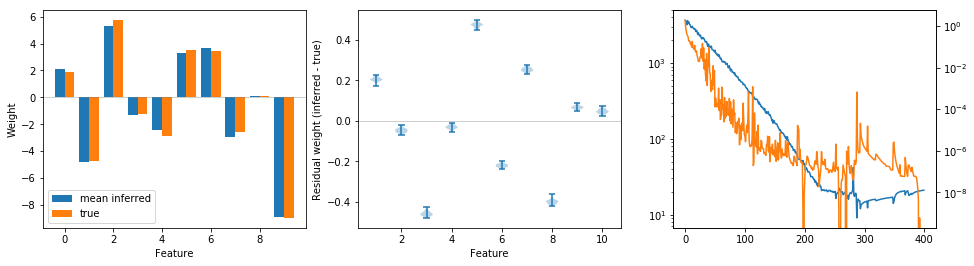

In [257]:
c0, c1 = get_color_cycle(2)
losses = np.asarray(losses)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.bar(np.arange(n_features) - 0.2, np.mean(z, axis=0), width=0.4, label='mean inferred')
plt.bar(np.arange(n_features) + 0.2, w, width=0.4, label='true')
plt.axhline(y=0, color='0.5', alpha=0.5, lw=0.75)
mpl_set(legend=True, xlabel='Feature', ylabel='Weight')

plt.subplot(1, 3, 2)
plt.violinplot(z - w[None, :])
plt.axhline(y=0, color='0.5', alpha=0.5, lw=0.75)
mpl_set(xlabel='Feature', ylabel='Residual weight (inferred - true)')

plt.subplot(1, 3, 3)
plt.plot(losses[:, 0], color=c0)
plt.yscale('log')
plt.twinx()
plt.plot(losses[:, 1], color=c1)
plt.yscale('log')

pass

# Misc

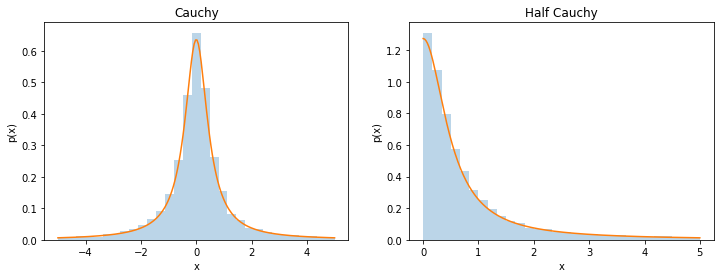

In [99]:
gamma = 0.5

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

u = np.random.uniform(size=10_000)
x = gamma * np.tan(np.pi * (u - 0.5))
_x = np.linspace(-gamma * 10, gamma * 10, 200)
_p = 1.0 / (np.pi * gamma * (1 + (_x / gamma) ** 2.0))

plt.hist(x, range=(-gamma * 10, gamma * 10), bins=31, normed=True, alpha=0.3)
plt.plot(_x, _p)
mpl_set(xlabel='x', ylabel='p(x)', title='Cauchy')

plt.subplot(1, 2, 2)

u = np.random.uniform(size=10_000)
x = gamma * np.tan(np.pi * 0.5 * u)
_x = np.linspace(0, gamma * 10, 200)
_p = 2.0 / (np.pi * gamma * (1 + (_x / gamma) ** 2.0))

plt.hist(x, range=(0, gamma * 10), bins=30, normed=True, alpha=0.3)
plt.plot(_x, _p)
mpl_set(xlabel='x', ylabel='p(x)', title='Half Cauchy')